In [98]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
from matplotlib.ticker import MaxNLocator
import numpy as np
from datetime import datetime
import calendar

In [29]:
DATA_CLEANED_PATH = '../data/interim/data_no_cancellations.parquet'
DATA_CANCELED_PATH = '../data/interim/data_cancellations.parquet'

In [31]:
data_cancellations = pd.read_parquet(DATA_CANCELED_PATH)
data_no_cancellations = pd.read_parquet(DATA_CLEANED_PATH)
data_cancellations.head()


hotel_id datum_dolaska datum_otkazivanja_rezervacije zemlja_gosta  \
0         0    2015-07-01                    2015-05-06          PRT   
1         0    2015-07-01                    2015-04-22          PRT   
2         0    2015-07-01                    2015-06-23          PRT   
3         0    2015-07-01                    2015-05-11          PRT   
4         0    2015-07-01                    2015-05-29          PRT   

   kanal_prodaje_id  tip_sobe_id  cijena_nocenja  gost_id  ukupno_gostiju  \
0                 2            1       61.437192  1075633               2   
1                 2            2      150.365262  1056139               2   
2                 2            3      142.635814  1020092               2   
3                 2            3      113.277032  1018277               2   
4                 0            3      105.416363  1035627               2   

   duljina_boravka  raspon_dolazak_rezervacija  
0                3                           1  
1                3                           3  
2                4                          75  
3                7                         178  
4               10                         181

Opis kolona:
- hotel_id : int, dvije vrste hotela: hotel 0 i hotel 1
- datum_dolaska :  datum kada bi gost trebao stići u hotel
- datum_otkazivanja_rezervacije: samo za podatkovni okvir s podacima o otkazanim rezervacijama
- zemlja_gosta : zemlja iz koje gost dolazi. Kategorije su zapisane u ISO 3155–3:2013 formatu
- kanal_prodaje_id : id kanala prodaje preko kojeg je rezervacija napravljena (primjeri: direktna rezervacija, agencija, online)
- tip_sobe_id : id tipa sobe koju je gost rezervirao
- cijena_nocenja : cijena jednog noćenja za pojedinu rezeraciju
- gost_id : identifikacijski broj gosta
- ukupno_gostiju : int, broj ukupnog broja gostiju za danu rezervaciju
- duljina_boravka: dani boravka osoba u hotelu u danoj rezervaciji
- raspon_dolazak_rezervacija : razlika u brojima dana izmedu dana dolaska gosta i dana kreiranja rezervacije

In [32]:
hotel_zero_cancellations = data_cancellations[data_cancellations['hotel_id'] == 0]
hotel_one_cancellations = data_cancellations[data_cancellations['hotel_id'] == 1]

assert (len(hotel_zero_cancellations)+ len(hotel_one_cancellations)) == len(data_cancellations)

In [33]:
hotel_zero_no_cancellations = data_no_cancellations[data_no_cancellations['hotel_id'] == 0]
hotel_one_no_cancellations = data_no_cancellations[data_no_cancellations['hotel_id'] == 1]

assert (len(hotel_zero_no_cancellations)+ len(hotel_one_no_cancellations)) == len(data_no_cancellations)

In [34]:
percent_hotel_zero_cancellations = (len(hotel_zero_cancellations) / len(data_cancellations)) * 100
percent_hotel_one_cancellations = (len(hotel_one_cancellations) / len(data_cancellations)) * 100
percent_hotel_zero_no_cancellations = (len(hotel_zero_no_cancellations) / len(data_no_cancellations)) * 100
percent_hotel_one_no_cancellations = (len(hotel_one_no_cancellations) / len(data_no_cancellations)) * 100

print(f"Prvi hotel ima {percent_hotel_zero_cancellations} % svih zapisa o otkazima u originalnom podatkovnom skupu")
print(f"Drugi hotel ima {percent_hotel_one_cancellations} % svih zapisa o otkazima u originalnom podatkovnom skupu")

print(f"Prvi hotel ima {percent_hotel_zero_no_cancellations} % svih zapisa bez otkaza u originalnom podatkovnom skupu")
print(f"Drugi hotel ima {percent_hotel_one_no_cancellations} % svih zapisa bez otkaza u originalnom podatkovnom skupu")

Prvi hotel ima 25.105485232067508 % svih zapisa o otkazima u originalnom podatkovnom skupu
Drugi hotel ima 74.89451476793249 % svih zapisa o otkazima u originalnom podatkovnom skupu
Prvi hotel ima 38.05994373512227 % svih zapisa bez otkaza u originalnom podatkovnom skupu
Drugi hotel ima 61.94005626487773 % svih zapisa bez otkaza u originalnom podatkovnom skupu


### Zanimaju nas zemlje podrijetla gostiju

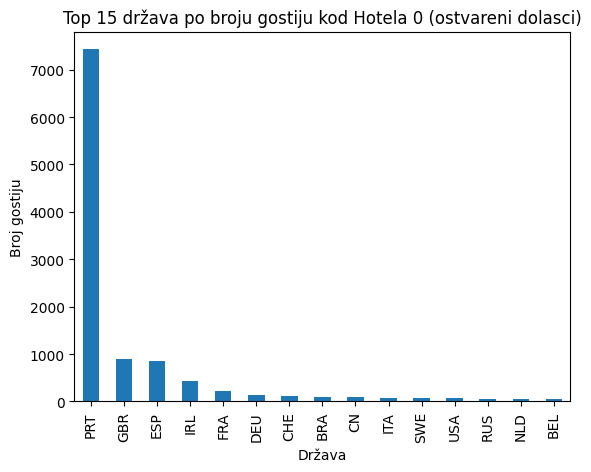

In [46]:
n = 15
top_countries_cancel_0 = hotel_zero_cancellations['zemlja_gosta'].value_counts()[0:n]
top_countries_cancel_0.plot(kind='bar')
plt.title(f'Top {n} država po broju gostiju kod Hotela 0 (ostvareni dolasci)')
plt.xlabel('Država')
plt.ylabel('Broj gostiju')
plt.show()

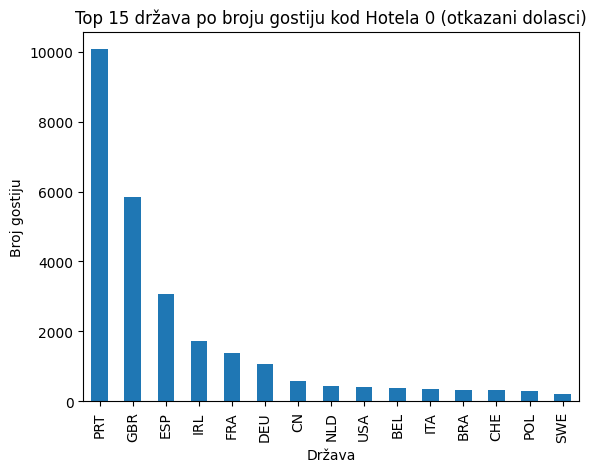

In [47]:
n = 15
top_countries_no_cancel_0 = hotel_zero_no_cancellations['zemlja_gosta'].value_counts()[0:n]
top_countries_no_cancel_0.plot(kind='bar')
plt.title(f'Top {n} država po broju gostiju kod Hotela 0 (otkazani dolasci)')
plt.xlabel('Država')
plt.ylabel('Broj gostiju')
plt.show()

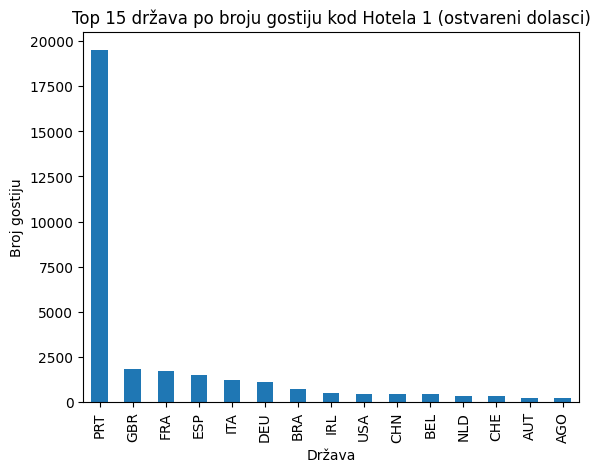

In [48]:
n = 15
top_countries_cancel_1 = hotel_one_cancellations['zemlja_gosta'].value_counts()[0:n]
top_countries_cancel_1.plot(kind='bar')
plt.title(f'Top {n} država po broju gostiju kod Hotela 1 (ostvareni dolasci)')
plt.xlabel('Država')
plt.ylabel('Broj gostiju')
plt.show()

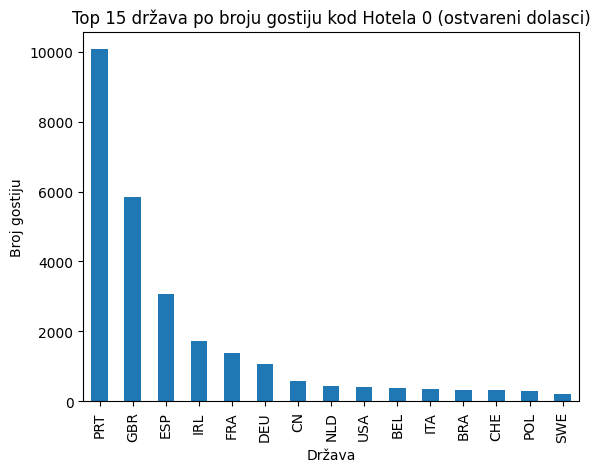

In [49]:
n = 15
top_countries_no_cancel_1 = hotel_zero_no_cancellations['zemlja_gosta'].value_counts()[0:n]
top_countries_no_cancel_1.plot(kind='bar')
plt.title(f'Top {n} država po broju gostiju kod Hotela 0 (ostvareni dolasci)')
plt.xlabel('Država')
plt.ylabel('Broj gostiju')
plt.show()

In [60]:
min_date = data_no_cancellations['datum_dolaska'].min()
max_date = data_no_cancellations['datum_dolaska'].max()

print(f"Svi zapisi su u razdoblju od {min_date} do {max_date}")

Svi zapisi su u razdoblju od 2015-01-01 00:00:00 do 2017-12-31 00:00:00


# Promatranje cijene u hotelima

- Gledamo cijene na sljedeći način:
    - za svaku rezervaciju dobijemo cijenu po osobi
    - za svaki dan/tjedan/mjesec dobijemo prosječnu cijenu (uzimajući i ne uzimajući godinu u obzir)
    - napravimo isto za različite vrste soba i kanala prodaje
    - napravimo sve prethodno za ostvarene i neostvarene rezervacije obaju hotela

In [75]:
# DODANO ZBOG PODIGNUTOG UPOZORENJA OD PYTHONA
hotel_zero_cancellations = hotel_zero_cancellations.copy()
hotel_one_cancellations = hotel_one_cancellations.copy()
hotel_zero_no_cancellations = hotel_zero_no_cancellations.copy()
hotel_one_no_cancellations = hotel_one_no_cancellations.copy()

In [81]:
hotel_zero_cancellations['datum_dolaska'] = pd.to_datetime(hotel_zero_cancellations['datum_dolaska'])
hotel_one_cancellations['datum_dolaska'] = pd.to_datetime(hotel_one_cancellations['datum_dolaska'])
hotel_zero_no_cancellations['datum_dolaska'] = pd.to_datetime(hotel_zero_no_cancellations['datum_dolaska'])
hotel_one_no_cancellations['datum_dolaska'] = pd.to_datetime(hotel_one_no_cancellations['datum_dolaska'])

KORAK 1: Cijena po osobi po rezervaciji

In [84]:
hotel_zero_cancellations.loc[:, 'cijena_nocenja_po_osobi'] = hotel_zero_cancellations['cijena_nocenja'] / hotel_zero_cancellations['ukupno_gostiju']
hotel_one_cancellations.loc[:, 'cijena_nocenja_po_osobi'] = hotel_one_cancellations['cijena_nocenja'] / hotel_one_cancellations['ukupno_gostiju']
hotel_zero_no_cancellations.loc[:, 'cijena_nocenja_po_osobi'] = hotel_zero_no_cancellations['cijena_nocenja'] / hotel_zero_no_cancellations['ukupno_gostiju']
hotel_one_no_cancellations.loc[:, 'cijena_nocenja_po_osobi'] = hotel_one_no_cancellations['cijena_nocenja'] / hotel_one_no_cancellations['ukupno_gostiju']

### HOTEL 0 otkazani dolasci

KORAK 2: Izračun prosječne dnevne, tjedne i mjesečne cijene po osobi

In [126]:
average_daily_price = hotel_zero_cancellations.groupby([hotel_zero_cancellations['datum_dolaska'].dt.year, hotel_zero_cancellations['datum_dolaska'].dt.date])['cijena_nocenja_po_osobi'].mean()
average_weekly_price = hotel_zero_cancellations.groupby([hotel_zero_cancellations['datum_dolaska'].dt.year, hotel_zero_cancellations['datum_dolaska'].dt.isocalendar().week])['cijena_nocenja_po_osobi'].mean()
average_monthly_price = hotel_zero_cancellations.groupby([hotel_zero_cancellations['datum_dolaska'].dt.year, hotel_zero_cancellations['datum_dolaska'].dt.month])['cijena_nocenja_po_osobi'].mean()


In [127]:
overall_average_monthly_price = hotel_zero_cancellations.groupby(hotel_zero_cancellations['datum_dolaska'].dt.month)['cijena_nocenja_po_osobi'].mean()
overall_average_weekly_price = hotel_zero_cancellations.groupby(hotel_zero_cancellations['datum_dolaska'].dt.isocalendar().week)['cijena_nocenja_po_osobi'].mean()


KORAK 3: Izračun prosječne dnevne, tjedne i mjesečne cijene po vrsti sobe

In [128]:
average_by_daily_room_type = hotel_zero_cancellations.groupby([hotel_zero_cancellations['datum_dolaska'].dt.date, 'tip_sobe_id'])['cijena_nocenja_po_osobi'].mean()
average_by_weekly_room_type = hotel_zero_cancellations.groupby([hotel_zero_cancellations['datum_dolaska'].dt.isocalendar().week, 'tip_sobe_id'])['cijena_nocenja_po_osobi'].mean()
average_by_monthly_room_type = hotel_zero_cancellations.groupby([hotel_zero_cancellations['datum_dolaska'].dt.month, 'tip_sobe_id'])['cijena_nocenja_po_osobi'].mean()

KORAK 4: Izračun prosječne dnevne, tjedne i mjesečne cijene po kanalu prodaje

In [129]:
average_by_daily_sales_channel = hotel_zero_cancellations.groupby([hotel_zero_cancellations['datum_dolaska'].dt.date, 'kanal_prodaje_id'])['cijena_nocenja_po_osobi'].mean()
average_by_monthly_sales_channel = hotel_zero_cancellations.groupby([hotel_zero_cancellations['datum_dolaska'].dt.month, 'kanal_prodaje_id'])['cijena_nocenja_po_osobi'].mean()
average_by_weekly_sales_channel = hotel_zero_cancellations.groupby([hotel_zero_cancellations['datum_dolaska'].dt.isocalendar().week, 'kanal_prodaje_id'])['cijena_nocenja_po_osobi'].mean()

### HOTEL 0 ostvareni dolasci

KORAK 2: Izračun prosječne dnevne, tjedne i mjesečne cijene po osobi

In [130]:
average_daily_price_hotel_zero_no = hotel_zero_no_cancellations.groupby([hotel_zero_no_cancellations['datum_dolaska'].dt.year, hotel_zero_no_cancellations['datum_dolaska'].dt.date])['cijena_nocenja_po_osobi'].mean()
average_weekly_price_hotel_zero_no = hotel_zero_no_cancellations.groupby([hotel_zero_no_cancellations['datum_dolaska'].dt.year, hotel_zero_no_cancellations['datum_dolaska'].dt.isocalendar().week])['cijena_nocenja_po_osobi'].mean()
average_monthly_price_hotel_zero_no = hotel_zero_no_cancellations.groupby([hotel_zero_no_cancellations['datum_dolaska'].dt.year, hotel_zero_no_cancellations['datum_dolaska'].dt.month])['cijena_nocenja_po_osobi'].mean()

In [131]:
overall_average_monthly_price_hotel_zero_no = hotel_zero_no_cancellations.groupby(hotel_zero_no_cancellations['datum_dolaska'].dt.month)['cijena_nocenja_po_osobi'].mean()
overall_average_weekly_price_hotel_zero_no = hotel_zero_no_cancellations.groupby(hotel_zero_no_cancellations['datum_dolaska'].dt.isocalendar().week)['cijena_nocenja_po_osobi'].mean()

KORAK 3: Izračun prosječne dnevne, tjedne i mjesečne cijene po vrsti sobe

In [132]:
average_by_daily_room_type_hotel_zero_no = hotel_zero_no_cancellations.groupby([hotel_zero_no_cancellations['datum_dolaska'].dt.date, 'tip_sobe_id'])['cijena_nocenja_po_osobi'].mean()
average_by_weekly_room_type_hotel_zero_no = hotel_zero_no_cancellations.groupby([hotel_zero_no_cancellations['datum_dolaska'].dt.isocalendar().week, 'tip_sobe_id'])['cijena_nocenja_po_osobi'].mean()
average_by_monthly_room_type_hotel_zero_no = hotel_zero_no_cancellations.groupby([hotel_zero_no_cancellations['datum_dolaska'].dt.month, 'tip_sobe_id'])['cijena_nocenja_po_osobi'].mean()

KORAK 4: Izračun prosječne dnevne, tjedne i mjesečne cijene po kanalu prodaje

In [133]:
average_by_daily_sales_channel_hotel_zero_no = hotel_zero_no_cancellations.groupby([hotel_zero_no_cancellations['datum_dolaska'].dt.date, 'kanal_prodaje_id'])['cijena_nocenja_po_osobi'].mean()
average_by_monthly_sales_channel_hotel_zero_no = hotel_zero_no_cancellations.groupby([hotel_zero_no_cancellations['datum_dolaska'].dt.month, 'kanal_prodaje_id'])['cijena_nocenja_po_osobi'].mean()
average_by_weekly_sales_channel_hotel_zero_no = hotel_zero_no_cancellations.groupby([hotel_zero_no_cancellations['datum_dolaska'].dt.isocalendar().week, 'kanal_prodaje_id'])['cijena_nocenja_po_osobi'].mean()

### HOTEL 1 ostvareni dolasci

KORAK 2: Izračun prosječne dnevne, tjedne i mjesečne cijene po osobi

In [134]:
average_daily_price_hotel_one_no = hotel_one_no_cancellations.groupby([hotel_one_no_cancellations['datum_dolaska'].dt.year, hotel_one_no_cancellations['datum_dolaska'].dt.date])['cijena_nocenja_po_osobi'].mean()
average_weekly_price_hotel_one_no = hotel_one_no_cancellations.groupby([hotel_one_no_cancellations['datum_dolaska'].dt.year, hotel_one_no_cancellations['datum_dolaska'].dt.isocalendar().week])['cijena_nocenja_po_osobi'].mean()
average_monthly_price_hotel_one_no = hotel_one_no_cancellations.groupby([hotel_one_no_cancellations['datum_dolaska'].dt.year, hotel_one_no_cancellations['datum_dolaska'].dt.month])['cijena_nocenja_po_osobi'].mean()


In [135]:
overall_average_monthly_price_hotel_one_no = hotel_one_no_cancellations.groupby(hotel_one_no_cancellations['datum_dolaska'].dt.month)['cijena_nocenja_po_osobi'].mean()
overall_average_weekly_price_hotel_one_no = hotel_one_no_cancellations.groupby(hotel_one_no_cancellations['datum_dolaska'].dt.isocalendar().week)['cijena_nocenja_po_osobi'].mean()


KORAK 3: Izračun prosječne dnevne, tjedne i mjesečne cijene po vrsti sobe

In [136]:
average_by_daily_room_type_hotel_one_no = hotel_one_no_cancellations.groupby([hotel_one_no_cancellations['datum_dolaska'].dt.date, 'tip_sobe_id'])['cijena_nocenja_po_osobi'].mean()
average_by_weekly_room_type_hotel_one_no = hotel_one_no_cancellations.groupby([hotel_one_no_cancellations['datum_dolaska'].dt.isocalendar().week, 'tip_sobe_id'])['cijena_nocenja_po_osobi'].mean()
average_by_monthly_room_type_hotel_one_no = hotel_one_no_cancellations.groupby([hotel_one_no_cancellations['datum_dolaska'].dt.month, 'tip_sobe_id'])['cijena_nocenja_po_osobi'].mean()


KORAK 4: Izračun prosječne dnevne, tjedne i mjesečne cijene po kanalu prodaje

In [137]:
average_by_daily_sales_channel_hotel_one_no = hotel_one_no_cancellations.groupby([hotel_one_no_cancellations['datum_dolaska'].dt.date, 'kanal_prodaje_id'])['cijena_nocenja_po_osobi'].mean()
average_by_monthly_sales_channel_hotel_one_no = hotel_one_no_cancellations.groupby([hotel_one_no_cancellations['datum_dolaska'].dt.month, 'kanal_prodaje_id'])['cijena_nocenja_po_osobi'].mean()
average_by_weekly_sales_channel_hotel_one_no = hotel_one_no_cancellations.groupby([hotel_one_no_cancellations['datum_dolaska'].dt.isocalendar().week, 'kanal_prodaje_id'])['cijena_nocenja_po_osobi'].mean()

### HOTEL 1 otkazani dolasci

KORAK 2: Izračun prosječne dnevne, tjedne i mjesečne cijene po osobi

In [138]:
average_daily_price_hotel_one = hotel_one_cancellations.groupby([hotel_one_cancellations['datum_dolaska'].dt.year, hotel_one_cancellations['datum_dolaska'].dt.date])['cijena_nocenja_po_osobi'].mean()
average_weekly_price_hotel_one = hotel_one_cancellations.groupby([hotel_one_cancellations['datum_dolaska'].dt.year, hotel_one_cancellations['datum_dolaska'].dt.isocalendar().week])['cijena_nocenja_po_osobi'].mean()
average_monthly_price_hotel_one = hotel_one_cancellations.groupby([hotel_one_cancellations['datum_dolaska'].dt.year, hotel_one_cancellations['datum_dolaska'].dt.month])['cijena_nocenja_po_osobi'].mean()


In [147]:

overall_average_monthly_price_hotel_one = hotel_one_cancellations.groupby(hotel_one_cancellations['datum_dolaska'].dt.month)['cijena_nocenja_po_osobi'].mean()
overall_average_weekly_price_hotel_one = hotel_one_cancellations.groupby(hotel_one_cancellations['datum_dolaska'].dt.isocalendar().week)['cijena_nocenja_po_osobi'].mean()

KORAK 3: Izračun prosječne dnevne, tjedne i mjesečne cijene po vrsti sobe

In [148]:
average_by_daily_room_type_hotel_one = hotel_one_cancellations.groupby([hotel_one_cancellations['datum_dolaska'].dt.date, 'tip_sobe_id'])['cijena_nocenja_po_osobi'].mean()
average_by_weekly_room_type_hotel_one = hotel_one_cancellations.groupby([hotel_one_cancellations['datum_dolaska'].dt.isocalendar().week, 'tip_sobe_id'])['cijena_nocenja_po_osobi'].mean()
average_by_monthly_room_type_hotel_one = hotel_one_cancellations.groupby([hotel_one_cancellations['datum_dolaska'].dt.month, 'tip_sobe_id'])['cijena_nocenja_po_osobi'].mean()

KORAK 4: Izračun prosječne dnevne, tjedne i mjesečne cijene po kanalu prodaje

In [149]:
average_by_daily_sales_channel_hotel_one = hotel_one_cancellations.groupby([hotel_one_cancellations['datum_dolaska'].dt.date, 'kanal_prodaje_id'])['cijena_nocenja_po_osobi'].mean()
average_by_monthly_sales_channel_hotel_one = hotel_one_cancellations.groupby([hotel_one_cancellations['datum_dolaska'].dt.month, 'kanal_prodaje_id'])['cijena_nocenja_po_osobi'].mean()
average_by_weekly_sales_channel_hotel_one = hotel_one_cancellations.groupby([hotel_one_cancellations['datum_dolaska'].dt.isocalendar().week, 'kanal_prodaje_id'])['cijena_nocenja_po_osobi'].mean()

##  Vizualizacije promjena cijena

### HOTEL 0 otkazani dolasci

<Figure size 1200x600 with 0 Axes>

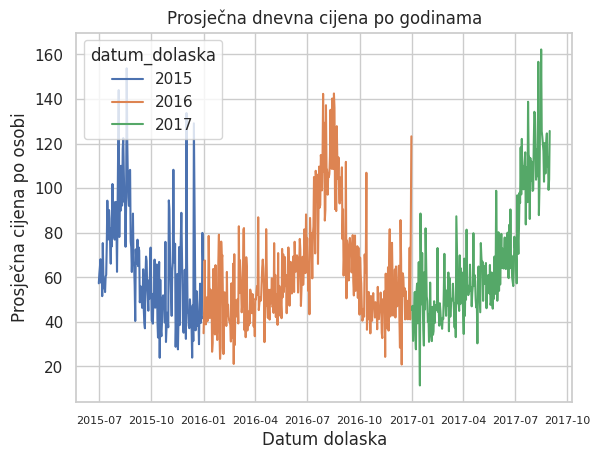

<Figure size 1200x600 with 0 Axes>

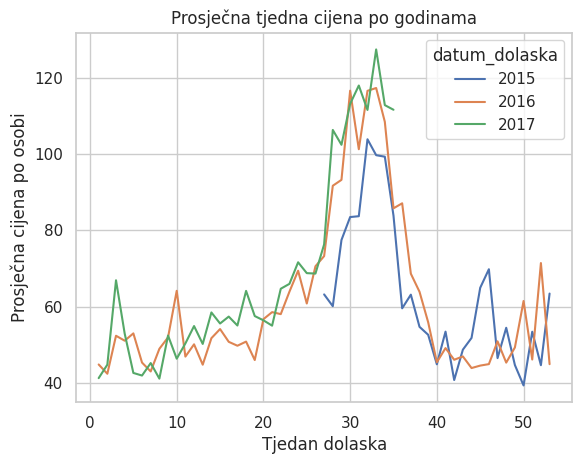

<Figure size 1200x600 with 0 Axes>

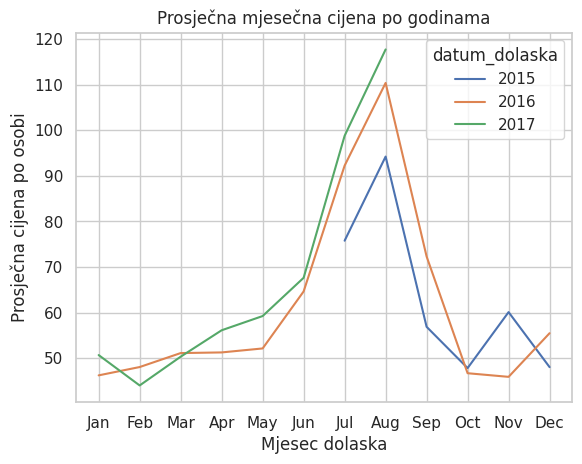

In [228]:
plt.figure(figsize=(12,6))
average_daily_price.unstack(level=0).plot()  
plt.title('Prosječna dnevna cijena po godinama')
plt.xlabel('Datum dolaska')
plt.xticks(fontsize=8)
plt.ylabel('Prosječna cijena po osobi')
plt.show()

plt.figure(figsize=(12,6))
average_weekly_price.unstack(level=0).plot()
plt.title('Prosječna tjedna cijena po godinama')
plt.xlabel('Tjedan dolaska')
plt.ylabel('Prosječna cijena po osobi')
plt.show()

plt.figure(figsize=(12,6))
average_monthly_price.unstack(level=0).plot()  
plt.title('Prosječna mjesečna cijena po godinama')
plt.xlabel('Mjesec dolaska')
plt.xticks(range(1, 13), [calendar.month_name[i][0:3] for i in range(1, 13)])
plt.ylabel('Prosječna cijena po osobi')
plt.show()

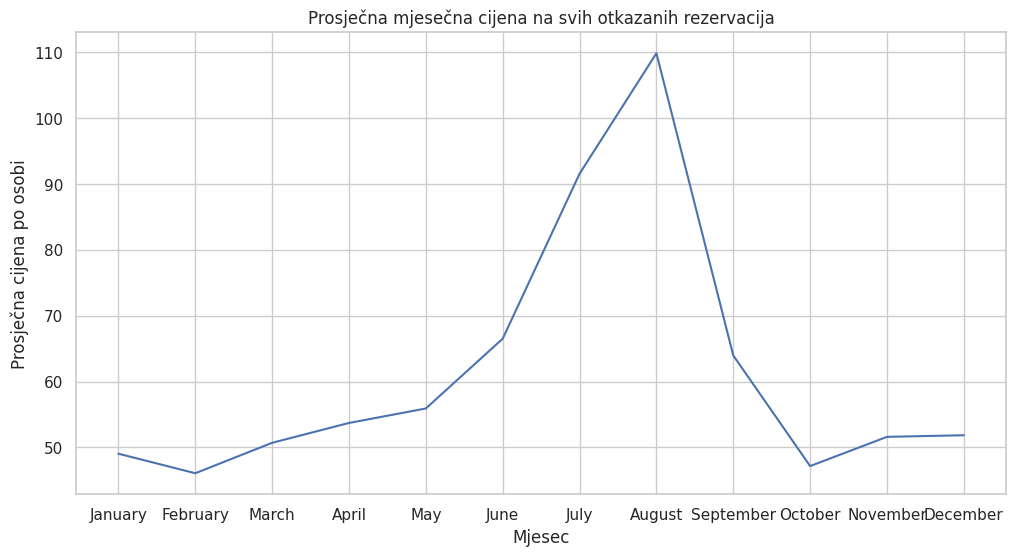

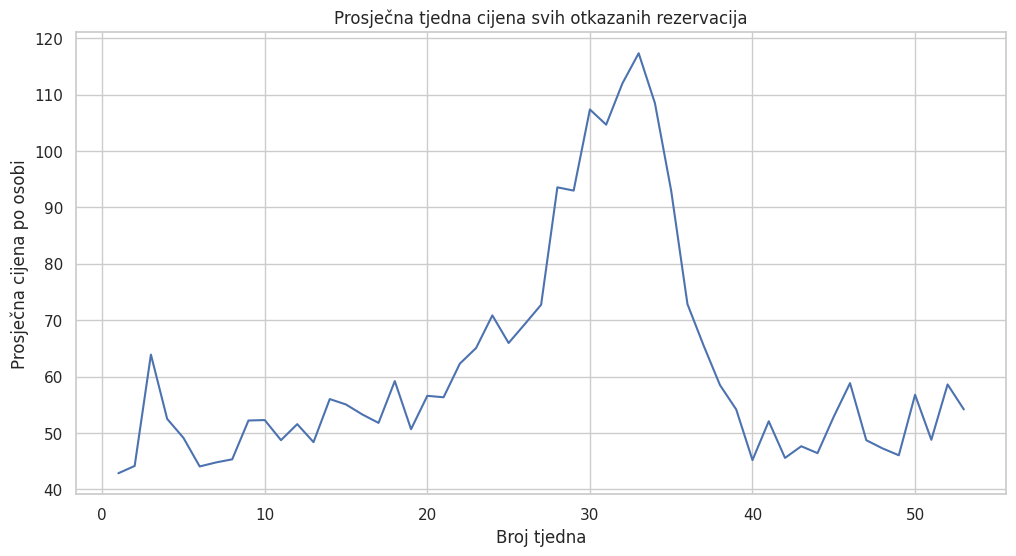

In [193]:
month_names = [calendar.month_name[i] for i in range(1, 13)]

plt.figure(figsize=(12, 6))
overall_average_monthly_price.plot()
plt.title('Prosječna mjesečna cijena na svih otkazanih rezervacija')
plt.xticks(range(1, 13), [calendar.month_name[i] for i in range(1, 13)])  
plt.xlabel('Mjesec')
plt.ylabel('Prosječna cijena po osobi')
plt.show()

plt.figure(figsize=(12, 6))
overall_average_weekly_price.plot()
plt.title('Prosječna tjedna cijena svih otkazanih rezervacija')
plt.xlabel('Broj tjedna')
plt.ylabel('Prosječna cijena po osobi')
plt.show()


<Figure size 2800x2000 with 0 Axes>

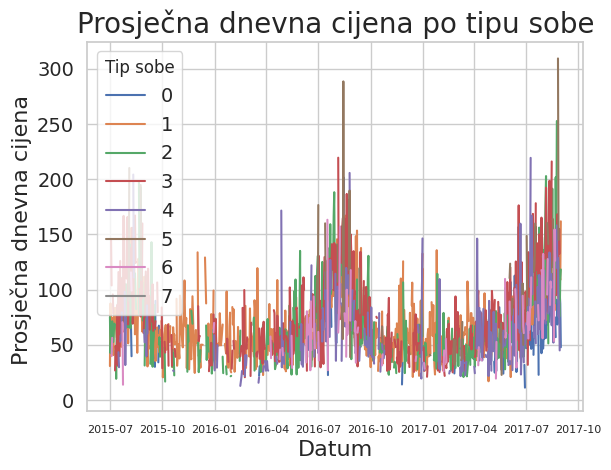

In [194]:
plt.figure(figsize=(28, 20))
average_by_daily_room_type.unstack(level=1).plot() 
plt.title('Prosječna dnevna cijena po tipu sobe', fontsize=20)
plt.xlabel('Datum', fontsize=16)
plt.ylabel('Prosječna dnevna cijena ', fontsize=16)
plt.xticks(fontsize=8)
plt.yticks(fontsize=14)
plt.legend(title='Tip sobe', fontsize=14)
plt.show()


<Figure size 2800x2000 with 0 Axes>

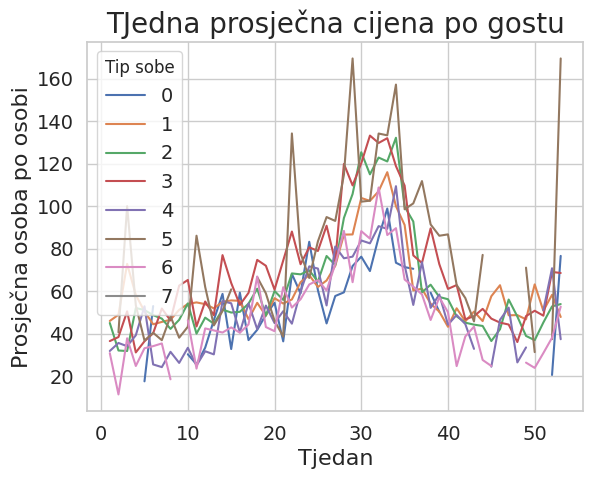

In [195]:
plt.figure(figsize=(28, 20))
average_by_weekly_room_type.unstack(level=1).plot()  
plt.title('TJedna prosječna cijena po gostu', fontsize=20)
plt.xlabel('Tjedan', fontsize=16)
plt.ylabel('Prosječna osoba po osobi', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(title='Tip sobe', fontsize=14)
plt.show()



<Figure size 2800x2000 with 0 Axes>

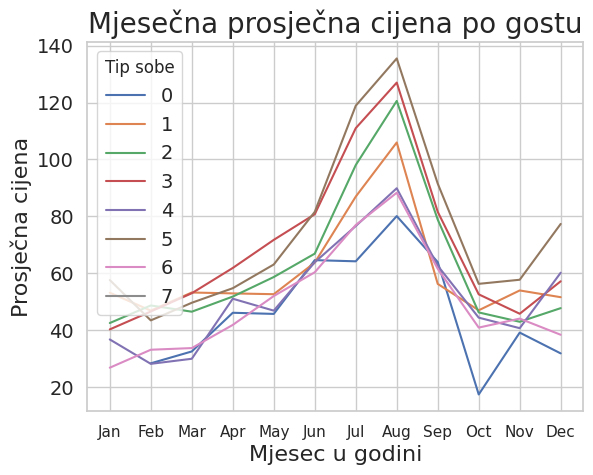

In [229]:
plt.figure(figsize=(28, 20))
average_by_monthly_room_type.unstack(level=1).plot() 
plt.title('Mjesečna prosječna cijena po gostu', fontsize=20)
plt.xlabel('Mjesec u godini', fontsize=16)
plt.ylabel('Prosječna cijena', fontsize=16)
plt.xticks(range(1, 13), [calendar.month_name[i][0:3] for i in range(1, 13)])
plt.yticks(fontsize=14)
plt.legend(title='Tip sobe', fontsize=14)
plt.show()


<Figure size 2800x2000 with 0 Axes>

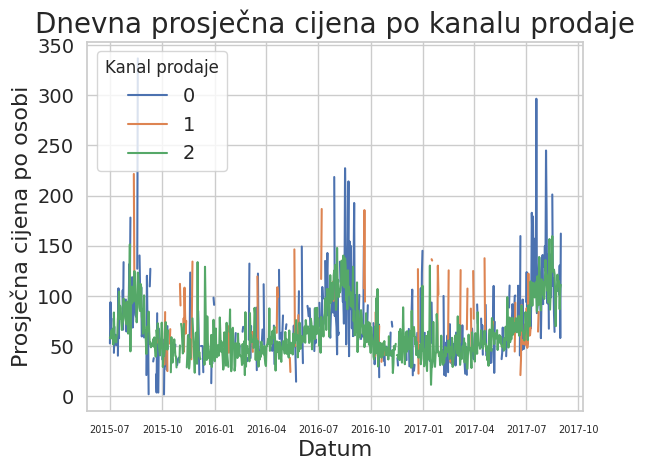

In [197]:
plt.figure(figsize=(28, 20))
average_by_daily_sales_channel.unstack(level=1).plot()  
plt.title('Dnevna prosječna cijena po kanalu prodaje', fontsize=20)
plt.xlabel('Datum', fontsize=16)
plt.ylabel('Prosječna cijena po osobi', fontsize=16)
plt.xticks(fontsize=7)
plt.yticks(fontsize=14)
plt.legend(title='Kanal prodaje', fontsize=14)
plt.show()


<Figure size 2800x2000 with 0 Axes>

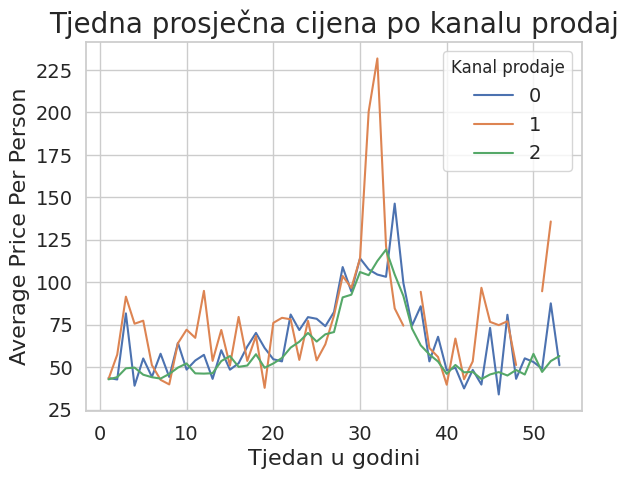

In [198]:
plt.figure(figsize=(28, 20))
average_by_weekly_sales_channel.unstack(level=1).plot()
plt.title('Tjedna prosječna cijena po kanalu prodaj', fontsize=20)
plt.xlabel('Tjedan u godini', fontsize=16)
plt.ylabel('Average Price Per Person', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(title='Kanal prodaje', fontsize=14)
plt.show()


<Figure size 2800x2000 with 0 Axes>

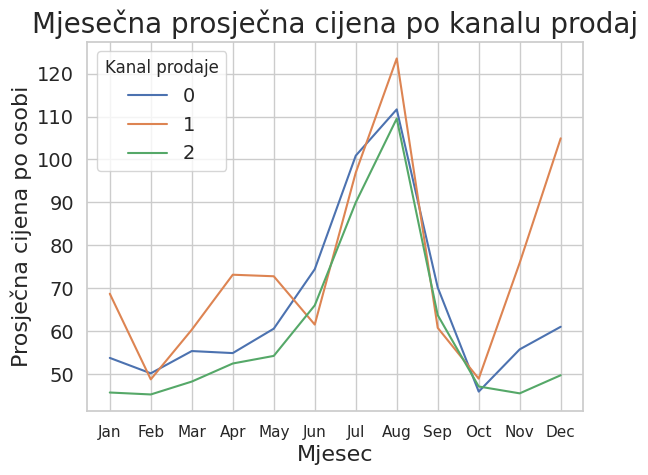

In [230]:
plt.figure(figsize=(28, 20))
average_by_monthly_sales_channel.unstack(level=1).plot()  
plt.title('Mjesečna prosječna cijena po kanalu prodaj', fontsize=20)
plt.xlabel('Mjesec', fontsize=16)
plt.ylabel('Prosječna cijena po osobi', fontsize=16)
plt.xticks(range(1, 13), [calendar.month_name[i][0:3] for i in range(1, 13)])
plt.yticks(fontsize=14)
plt.legend(title='Kanal prodaje', fontsize=14)
plt.show()



### HOTEL 0 ostvareni dolasci

<Figure size 2800x2000 with 0 Axes>

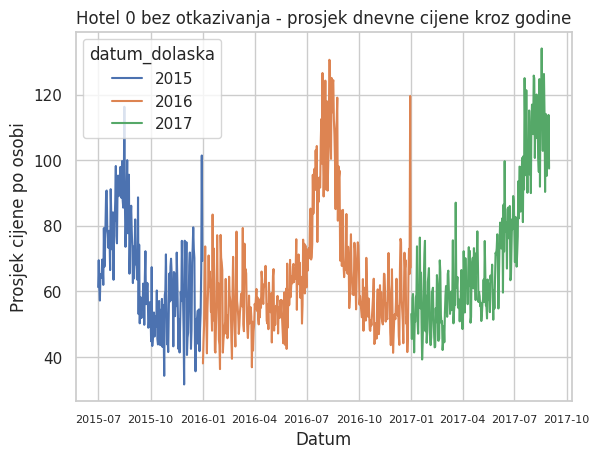

In [231]:
plt.figure(figsize=(28, 20))
average_daily_price_hotel_zero_no.unstack(level=0).plot()
plt.title('Hotel 0 bez otkazivanja - prosjek dnevne cijene kroz godine')
plt.xlabel('Datum')
plt.xticks(fontsize=8)
plt.ylabel('Prosjek cijene po osobi')
plt.show()


<Figure size 2800x2000 with 0 Axes>

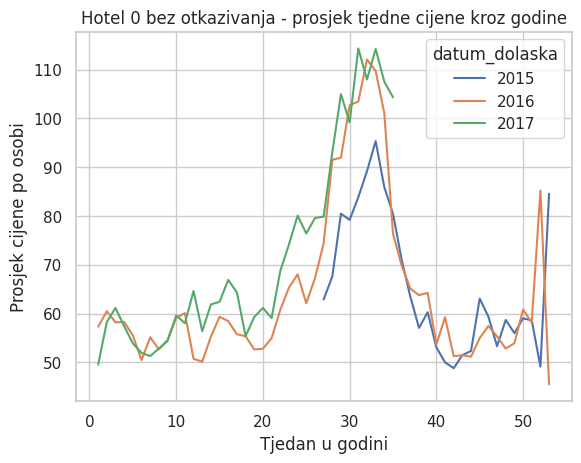

In [201]:
plt.figure(figsize=(28, 20))
average_weekly_price_hotel_zero_no.unstack(level=0).plot()
plt.title('Hotel 0 bez otkazivanja - prosjek tjedne cijene kroz godine')
plt.xlabel('Tjedan u godini')
plt.ylabel('Prosjek cijene po osobi')
plt.show()

<Figure size 2800x2000 with 0 Axes>

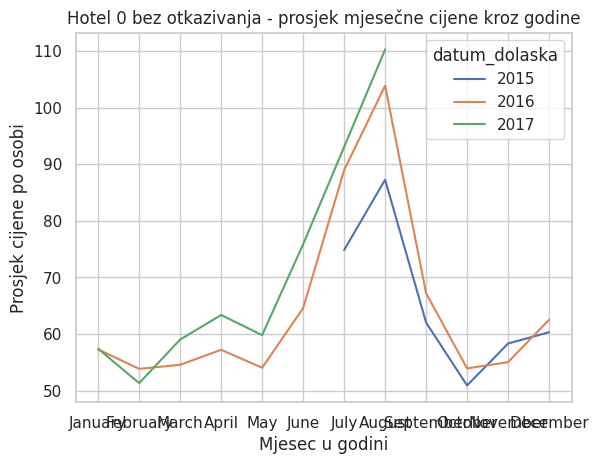

In [202]:
plt.figure(figsize=(28, 20))
average_monthly_price_hotel_zero_no.unstack(level=0).plot()
plt.title('Hotel 0 bez otkazivanja - prosjek mjesečne cijene kroz godine')
plt.xlabel('Mjesec u godini')
plt.ylabel('Prosjek cijene po osobi')
plt.xticks(range(1, 13), [calendar.month_name[i] for i in range(1, 13)])
plt.show()


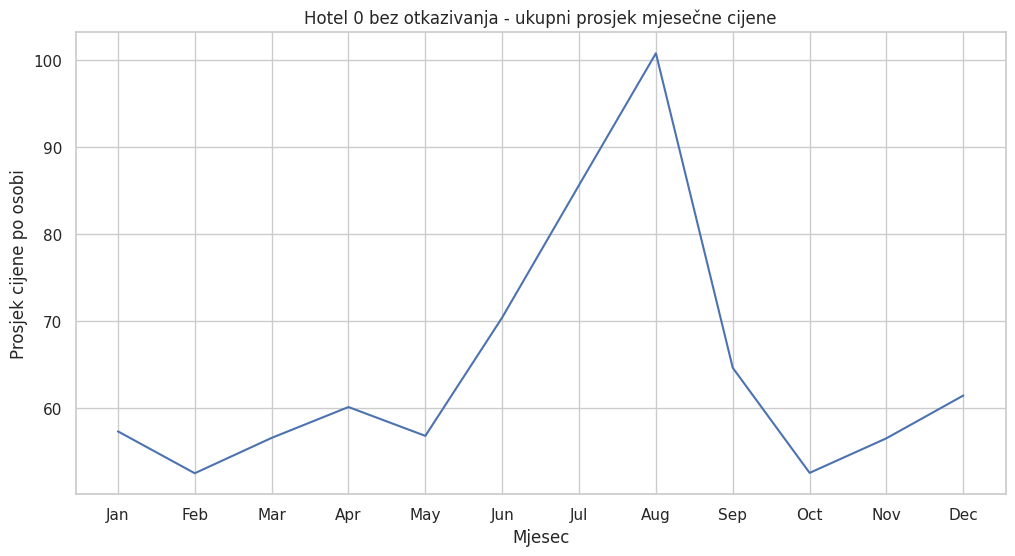

In [232]:
plt.figure(figsize=(12, 6))
overall_average_monthly_price_hotel_zero_no.plot()
plt.title('Hotel 0 bez otkazivanja - ukupni prosjek mjesečne cijene')
plt.xticks(range(1, 13), [calendar.month_name[i][0:3] for i in range(1, 13)])
plt.xlabel('Mjesec')
plt.ylabel('Prosjek cijene po osobi')
plt.show()

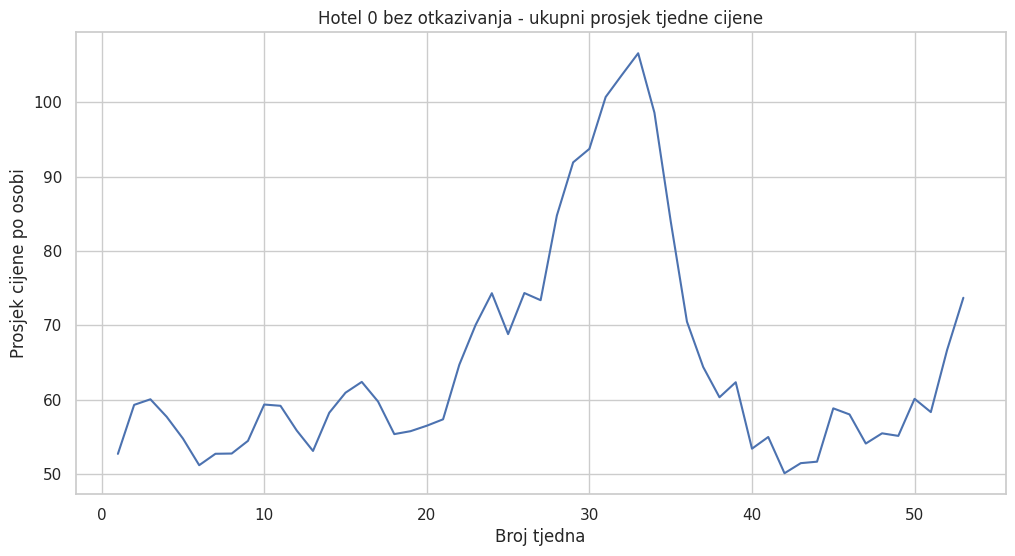

In [204]:
plt.figure(figsize=(12, 6))
overall_average_weekly_price_hotel_zero_no.plot()
plt.title('Hotel 0 bez otkazivanja - ukupni prosjek tjedne cijene')
plt.xlabel('Broj tjedna')
plt.ylabel('Prosjek cijene po osobi')
plt.show()


<Figure size 2800x2000 with 0 Axes>

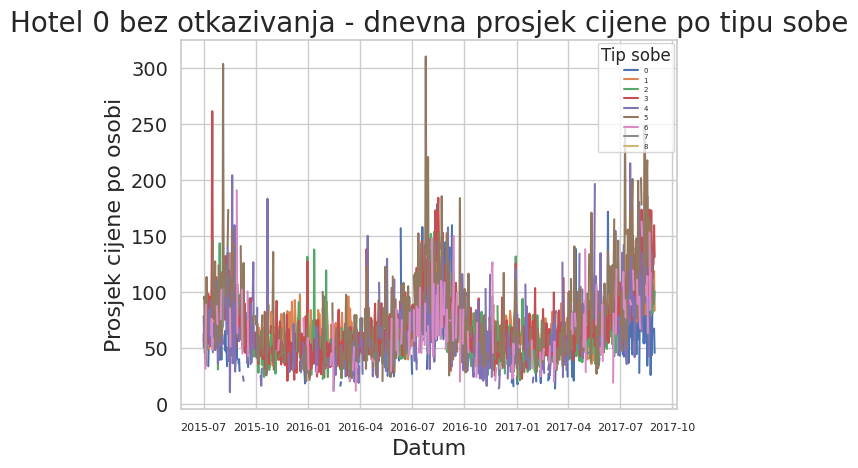

In [251]:
plt.figure(figsize=(28, 20))
average_by_daily_room_type_hotel_zero_no.unstack(level=1).plot()
plt.title('Hotel 0 bez otkazivanja - dnevna prosjek cijene po tipu sobe', fontsize=20)
plt.xlabel('Datum', fontsize=16)
plt.ylabel('Prosjek cijene po osobi', fontsize=16)
plt.xticks(fontsize=8)
plt.yticks(fontsize=14)
plt.legend(title='Tip sobe', fontsize=5)
plt.show()


<Figure size 2800x2000 with 0 Axes>

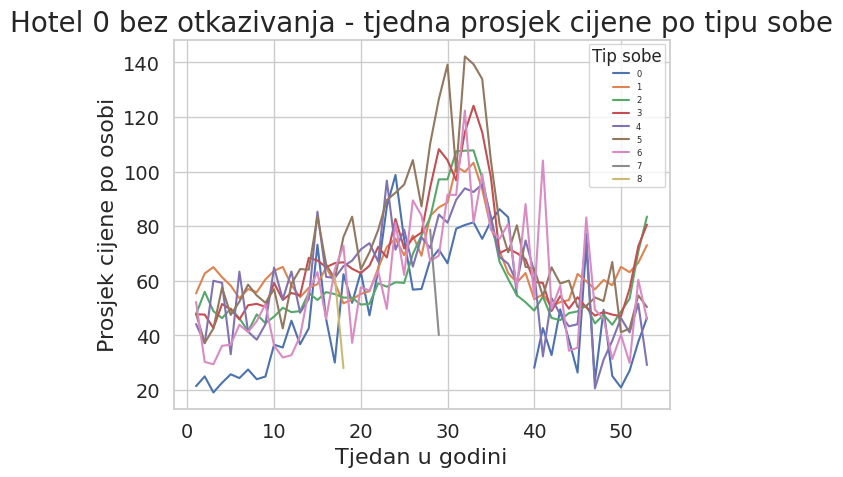

In [252]:
plt.figure(figsize=(28, 20))
average_by_weekly_room_type_hotel_zero_no.unstack(level=1).plot()
plt.title('Hotel 0 bez otkazivanja - tjedna prosjek cijene po tipu sobe', fontsize=20)
plt.xlabel('Tjedan u godini', fontsize=16)
plt.ylabel('Prosjek cijene po osobi', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(title='Tip sobe', fontsize=6)
plt.show()

<Figure size 2800x2000 with 0 Axes>

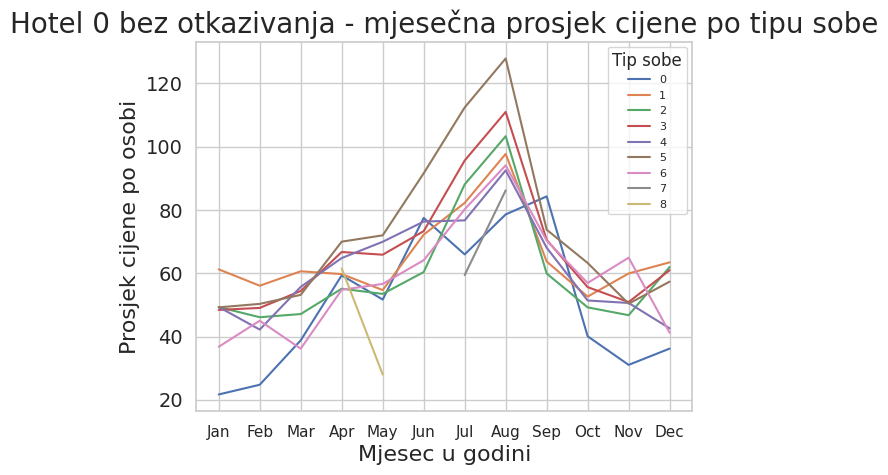

In [233]:
plt.figure(figsize=(28, 20))
average_by_monthly_room_type_hotel_zero_no.unstack(level=1).plot()
plt.title('Hotel 0 bez otkazivanja - mjesečna prosjek cijene po tipu sobe', fontsize=20)
plt.xlabel('Mjesec u godini', fontsize=16)
plt.ylabel('Prosjek cijene po osobi', fontsize=16)
plt.xticks(range(1, 13), [calendar.month_name[i][0:3] for i in range(1, 13)])
plt.yticks(fontsize=14)
plt.legend(title='Tip sobe', fontsize=8)
plt.show()

<Figure size 2800x2000 with 0 Axes>

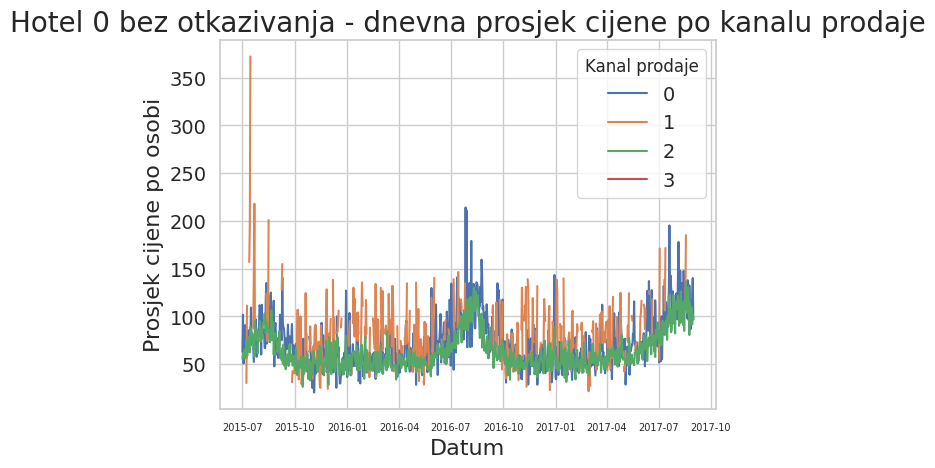

In [208]:
plt.figure(figsize=(28, 20))
average_by_daily_sales_channel_hotel_zero_no.unstack(level=1).plot()
plt.title('Hotel 0 bez otkazivanja - dnevna prosjek cijene po kanalu prodaje', fontsize=20)
plt.xlabel('Datum', fontsize=16)
plt.ylabel('Prosjek cijene po osobi', fontsize=16)
plt.xticks(fontsize=7)
plt.yticks(fontsize=14)
plt.legend(title='Kanal prodaje', fontsize=14)
plt.show()


<Figure size 2800x2000 with 0 Axes>

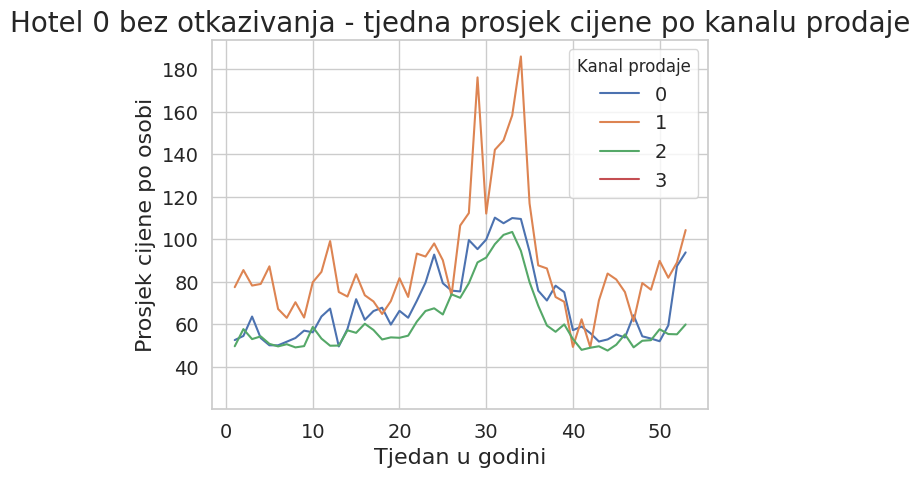

In [209]:
plt.figure(figsize=(28, 20))
average_by_weekly_sales_channel_hotel_zero_no.unstack(level=1).plot()
plt.title('Hotel 0 bez otkazivanja - tjedna prosjek cijene po kanalu prodaje', fontsize=20)
plt.xlabel('Tjedan u godini', fontsize=16)
plt.ylabel('Prosjek cijene po osobi', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(title='Kanal prodaje', fontsize=14)
plt.show()

<Figure size 2800x2000 with 0 Axes>

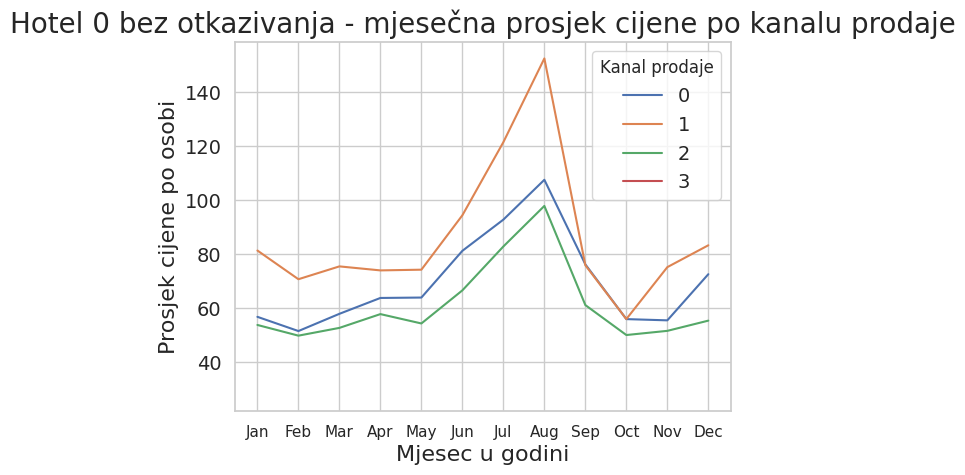

In [234]:
plt.figure(figsize=(28, 20))
average_by_monthly_sales_channel_hotel_zero_no.unstack(level=1).plot()
plt.title('Hotel 0 bez otkazivanja - mjesečna prosjek cijene po kanalu prodaje', fontsize=20)
plt.xlabel('Mjesec u godini', fontsize=16)
plt.ylabel('Prosjek cijene po osobi', fontsize=16)
plt.xticks(range(1, 13), [calendar.month_name[i][0:3] for i in range(1, 13)])
plt.yticks(fontsize=14)
plt.legend(title='Kanal prodaje', fontsize=14)
plt.show()

### HOTEL 1 otkazani dolasci

<Figure size 2800x2000 with 0 Axes>

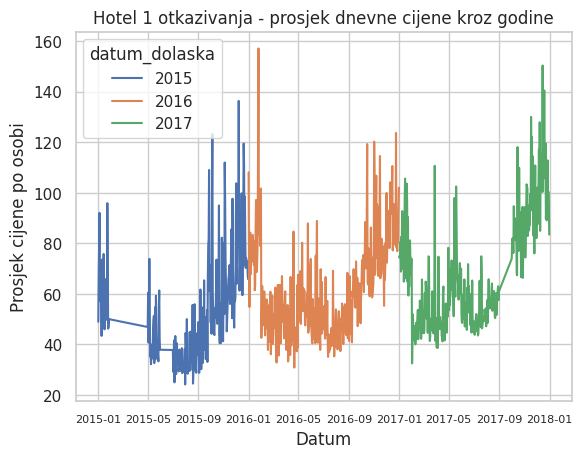

In [235]:
plt.figure(figsize=(28, 20))
average_daily_price_hotel_one.unstack(level=0).plot()
plt.title('Hotel 1 otkazivanja - prosjek dnevne cijene kroz godine')
plt.xlabel('Datum')
plt.xticks(fontsize=8)
plt.ylabel('Prosjek cijene po osobi')
plt.show()


<Figure size 2800x2000 with 0 Axes>

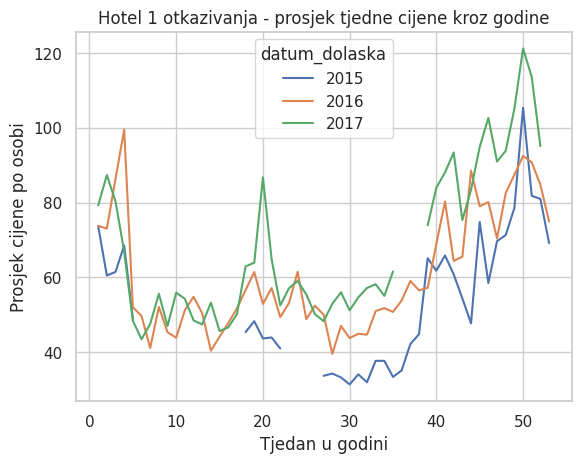

In [212]:
plt.figure(figsize=(28, 20))
average_weekly_price_hotel_one.unstack(level=0).plot()
plt.title('Hotel 1 otkazivanja - prosjek tjedne cijene kroz godine')
plt.xlabel('Tjedan u godini')
plt.ylabel('Prosjek cijene po osobi')
plt.show()


<Figure size 2800x2000 with 0 Axes>

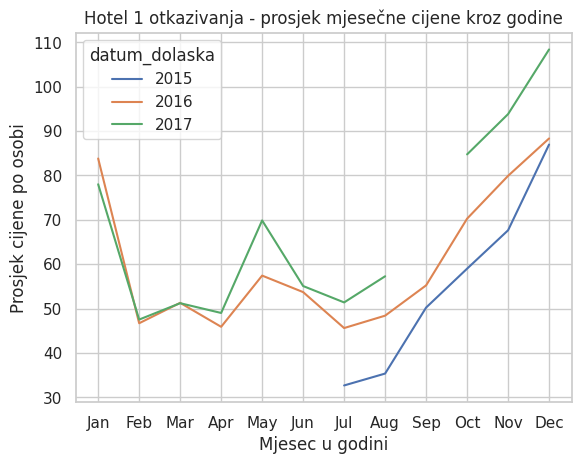

In [236]:
plt.figure(figsize=(28, 20))
average_monthly_price_hotel_one.unstack(level=0).plot()
plt.title('Hotel 1 otkazivanja - prosjek mjesečne cijene kroz godine')
plt.xlabel('Mjesec u godini')
plt.ylabel('Prosjek cijene po osobi')
plt.xticks(range(1, 13), [calendar.month_name[i][0:3] for i in range(1, 13)])
plt.show()


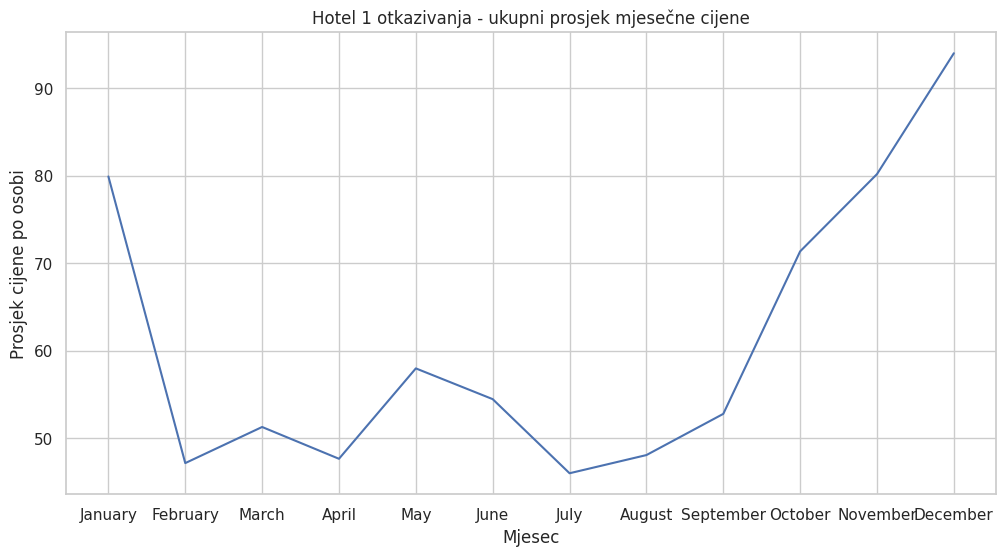

In [214]:
plt.figure(figsize=(12, 6))
overall_average_monthly_price_hotel_one.plot()
plt.title('Hotel 1 otkazivanja - ukupni prosjek mjesečne cijene')
plt.xticks(range(1, 13), [calendar.month_name[i] for i in range(1, 13)])
plt.xlabel('Mjesec')
plt.ylabel('Prosjek cijene po osobi')
plt.show()

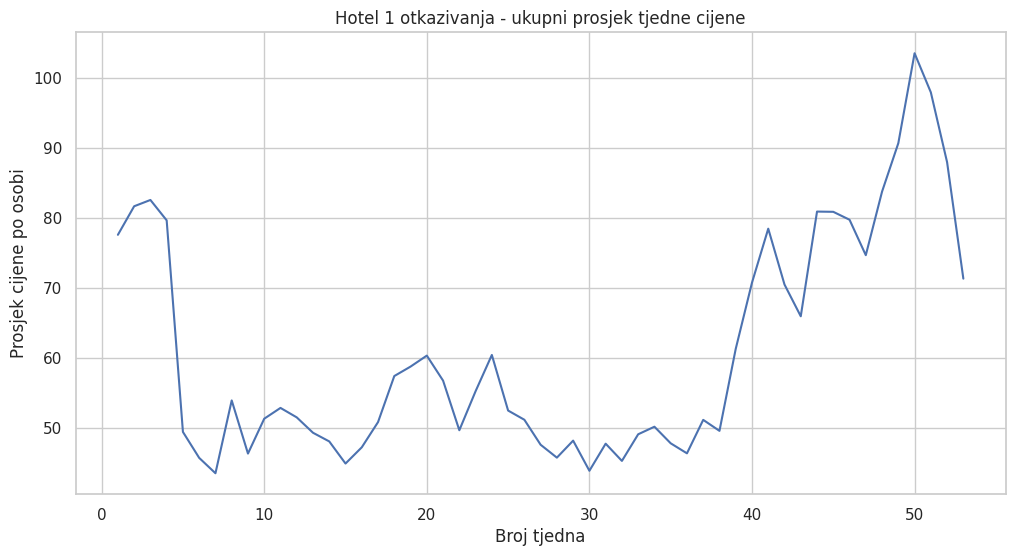

In [237]:
plt.figure(figsize=(12, 6))
overall_average_weekly_price_hotel_one.plot()
plt.title('Hotel 1 otkazivanja - ukupni prosjek tjedne cijene')
plt.xlabel('Broj tjedna')
plt.ylabel('Prosjek cijene po osobi')
plt.show()

<Figure size 2800x2000 with 0 Axes>

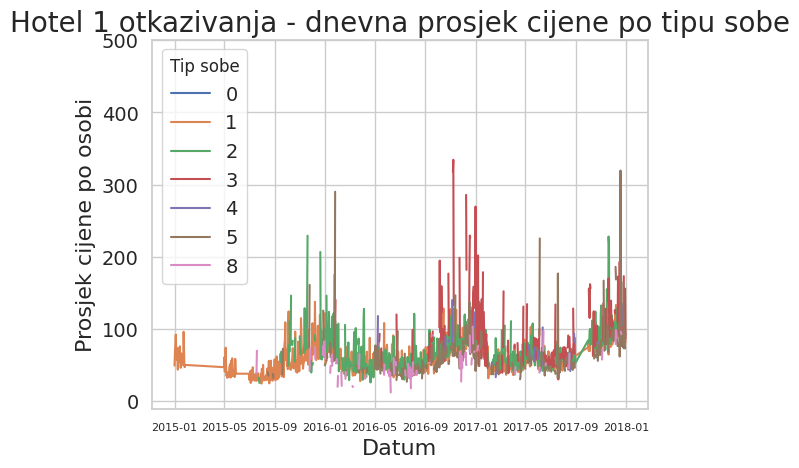

In [238]:
plt.figure(figsize=(28, 20))
average_by_daily_room_type_hotel_one.unstack(level=1).plot()
plt.title('Hotel 1 otkazivanja - dnevna prosjek cijene po tipu sobe', fontsize=20)
plt.xlabel('Datum', fontsize=16)
plt.ylabel('Prosjek cijene po osobi', fontsize=16)
plt.xticks(fontsize=8)
plt.yticks(fontsize=14)
plt.legend(title='Tip sobe', fontsize=14)
plt.show()

<Figure size 2800x2000 with 0 Axes>

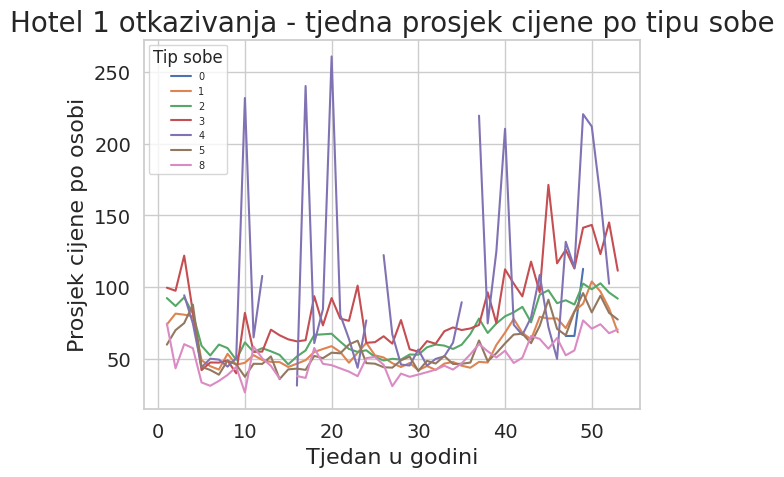

In [253]:
plt.figure(figsize=(28, 20))
average_by_weekly_room_type_hotel_one.unstack(level=1).plot()
plt.title('Hotel 1 otkazivanja - tjedna prosjek cijene po tipu sobe', fontsize=20)
plt.xlabel('Tjedan u godini', fontsize=16)
plt.ylabel('Prosjek cijene po osobi', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(title='Tip sobe', fontsize=7)
plt.show()

<Figure size 2800x2000 with 0 Axes>

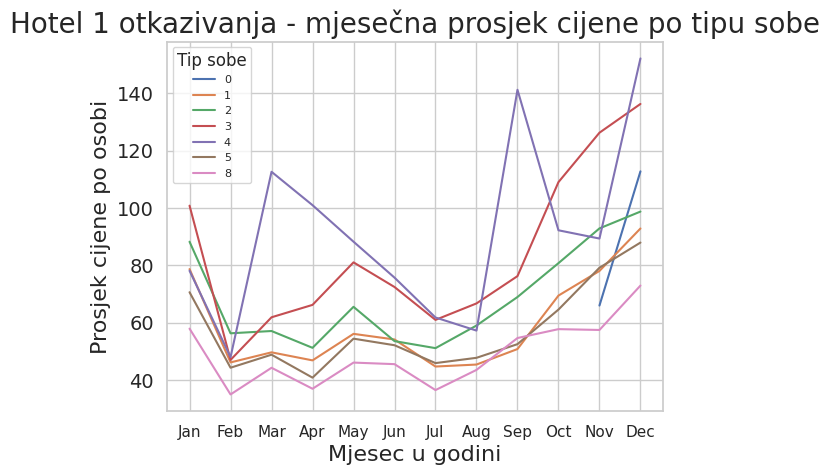

In [245]:
plt.figure(figsize=(28, 20))
average_by_monthly_room_type_hotel_one.unstack(level=1).plot()
plt.title('Hotel 1 otkazivanja - mjesečna prosjek cijene po tipu sobe', fontsize=20)
plt.xlabel('Mjesec u godini', fontsize=16)
plt.ylabel('Prosjek cijene po osobi', fontsize=16)
plt.xticks(range(1, 13), [calendar.month_name[i][0:3] for i in range(1, 13)])
plt.yticks(fontsize=14)
plt.legend(title='Tip sobe', fontsize=8)
plt.show()

<Figure size 2800x2000 with 0 Axes>

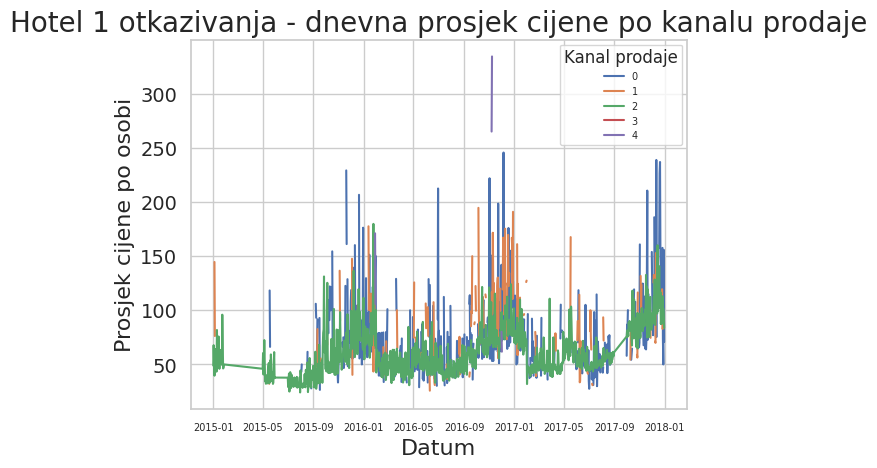

In [246]:
plt.figure(figsize=(28, 20))
average_by_daily_sales_channel_hotel_one.unstack(level=1).plot()
plt.title('Hotel 1 otkazivanja - dnevna prosjek cijene po kanalu prodaje', fontsize=20)
plt.xlabel('Datum', fontsize=16)
plt.ylabel('Prosjek cijene po osobi', fontsize=16)
plt.xticks(fontsize=7)
plt.yticks(fontsize=14)
plt.legend(title='Kanal prodaje', fontsize=7)
plt.show()

<Figure size 2800x2000 with 0 Axes>

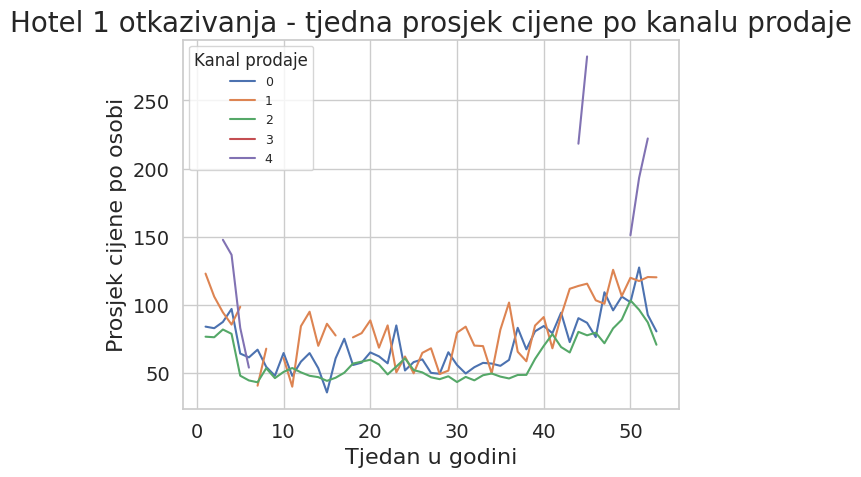

In [248]:
plt.figure(figsize=(28, 20))
average_by_weekly_sales_channel_hotel_one.unstack(level=1).plot()
plt.title('Hotel 1 otkazivanja - tjedna prosjek cijene po kanalu prodaje', fontsize=20)
plt.xlabel('Tjedan u godini', fontsize=16)
plt.ylabel('Prosjek cijene po osobi', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(title='Kanal prodaje', fontsize=9)
plt.show()

<Figure size 2800x2000 with 0 Axes>

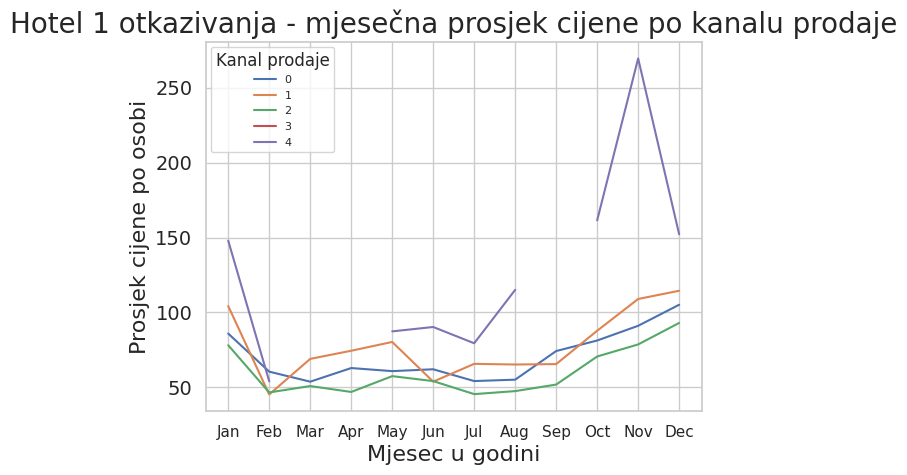

In [249]:
plt.figure(figsize=(28, 20))
average_by_monthly_sales_channel_hotel_one.unstack(level=1).plot()
plt.title('Hotel 1 otkazivanja - mjesečna prosjek cijene po kanalu prodaje', fontsize=20)
plt.xlabel('Mjesec u godini', fontsize=16)
plt.ylabel('Prosjek cijene po osobi', fontsize=16)
plt.xticks(range(1, 13), [calendar.month_name[i][0:3] for i in range(1, 13)])
plt.yticks(fontsize=14)
plt.legend(title='Kanal prodaje', fontsize=8)
plt.show()

### HOTEL 1 ostvareni dolasci

<Figure size 2800x2000 with 0 Axes>

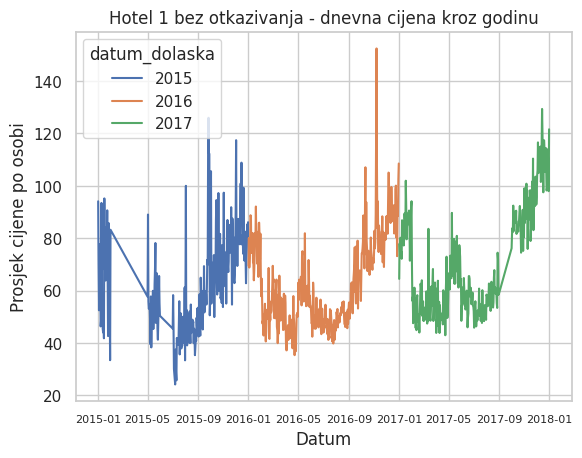

In [217]:
plt.figure(figsize=(28, 20))
average_daily_price_hotel_one_no.unstack(level=0).plot()
plt.title('Hotel 1 bez otkazivanja - dnevna cijena kroz godinu')
plt.xlabel('Datum')
plt.xticks(fontsize=8)
plt.ylabel('Prosjek cijene po osobi')
plt.show()

<Figure size 2800x2000 with 0 Axes>

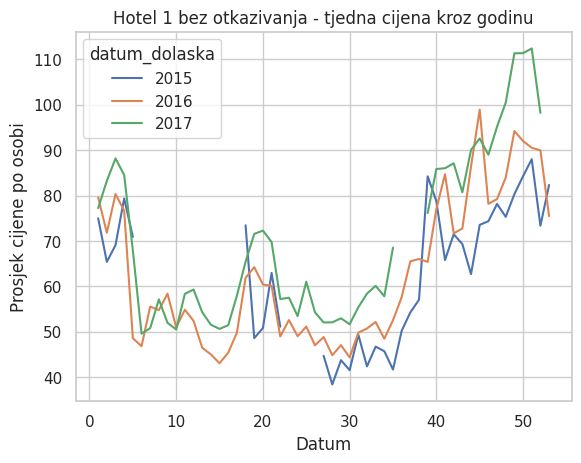

In [218]:
plt.figure(figsize=(28, 20))
average_weekly_price_hotel_one_no.unstack(level=0).plot()
plt.title('Hotel 1 bez otkazivanja - tjedna cijena kroz godinu')
plt.xlabel('Datum')
plt.ylabel('Prosjek cijene po osobi')
plt.show()


<Figure size 2800x2000 with 0 Axes>

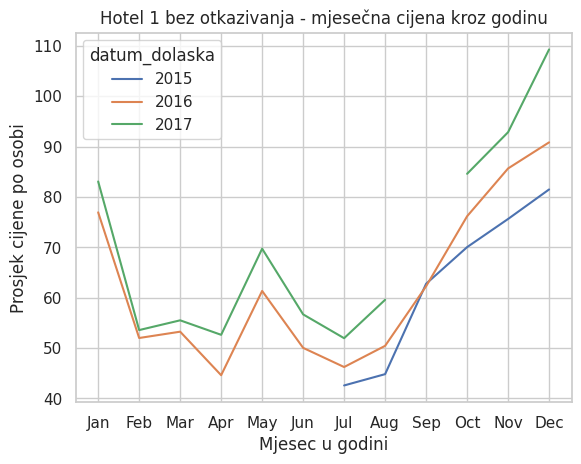

In [219]:
plt.figure(figsize=(28, 20))
average_monthly_price_hotel_one_no.unstack(level=0).plot()
plt.title('Hotel 1 bez otkazivanja - mjesečna cijena kroz godinu')
plt.xlabel('Mjesec u godini')
plt.ylabel('Prosjek cijene po osobi')
plt.xticks(range(1, 13), [calendar.month_name[i][0:3] for i in range(1, 13)])
plt.show()

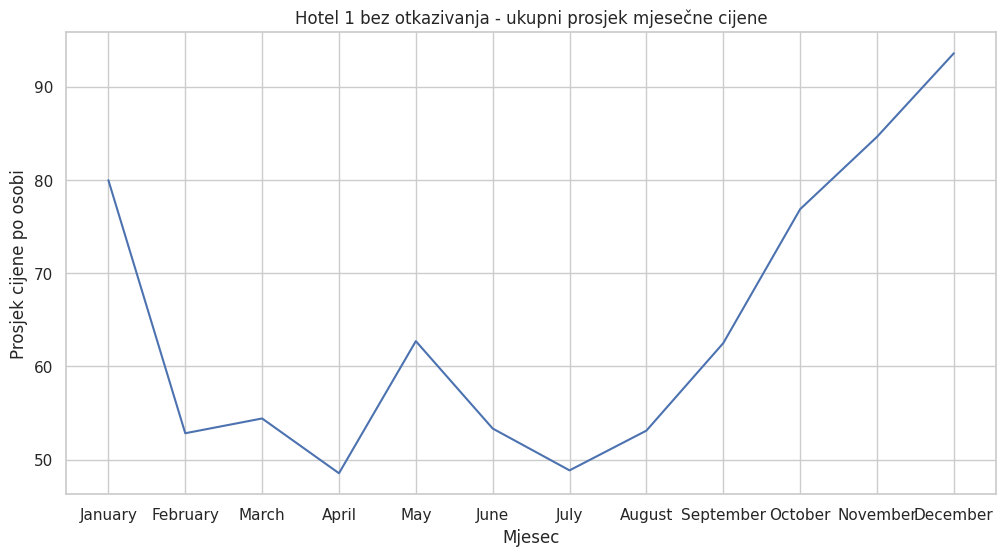

In [220]:
plt.figure(figsize=(12, 6))
overall_average_monthly_price_hotel_one_no.plot()
plt.title('Hotel 1 bez otkazivanja - ukupni prosjek mjesečne cijene')
plt.xticks(range(1, 13), [calendar.month_name[i] for i in range(1, 13)])
plt.xlabel('Mjesec')
plt.ylabel('Prosjek cijene po osobi')
plt.show()


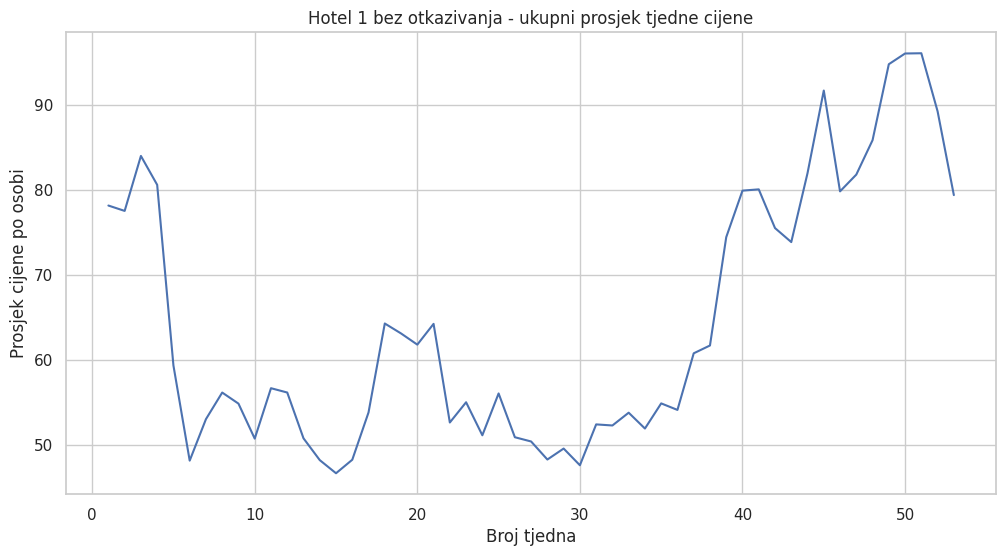

In [221]:
plt.figure(figsize=(12, 6))
overall_average_weekly_price_hotel_one_no.plot()
plt.title('Hotel 1 bez otkazivanja - ukupni prosjek tjedne cijene')
plt.xlabel('Broj tjedna')
plt.ylabel('Prosjek cijene po osobi')
plt.show()



<Figure size 2800x2000 with 0 Axes>

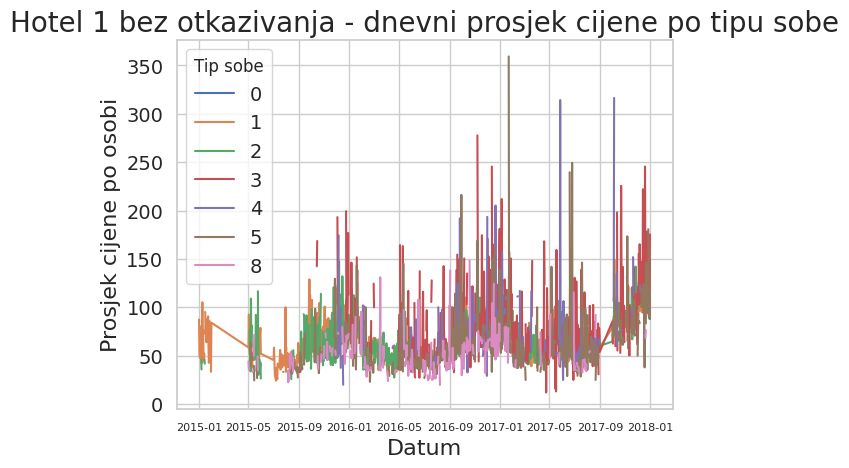

In [222]:
plt.figure(figsize=(28, 20))
average_by_daily_room_type_hotel_one_no.unstack(level=1).plot()
plt.title('Hotel 1 bez otkazivanja - dnevni prosjek cijene po tipu sobe', fontsize=20)
plt.xlabel('Datum', fontsize=16)
plt.ylabel('Prosjek cijene po osobi', fontsize=16)
plt.xticks(fontsize=8)
plt.yticks(fontsize=14)
plt.legend(title='Tip sobe', fontsize=14)
plt.show()




<Figure size 2800x2000 with 0 Axes>

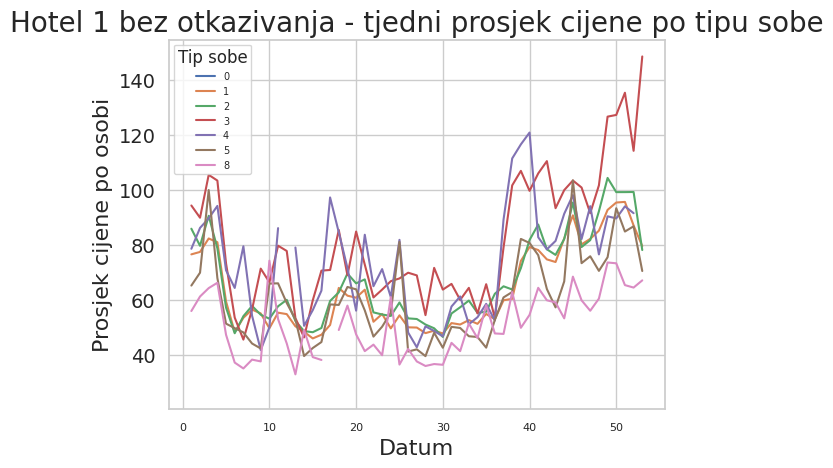

In [223]:
plt.figure(figsize=(28, 20))
average_by_weekly_room_type_hotel_one_no.unstack(level=1).plot()
plt.title('Hotel 1 bez otkazivanja - tjedni prosjek cijene po tipu sobe', fontsize=20)
plt.xlabel('Datum', fontsize=16)
plt.ylabel('Prosjek cijene po osobi', fontsize=16)
plt.xticks(fontsize=8)
plt.yticks(fontsize=14)
plt.legend(title='Tip sobe', fontsize=7)
plt.show()





<Figure size 2800x2000 with 0 Axes>

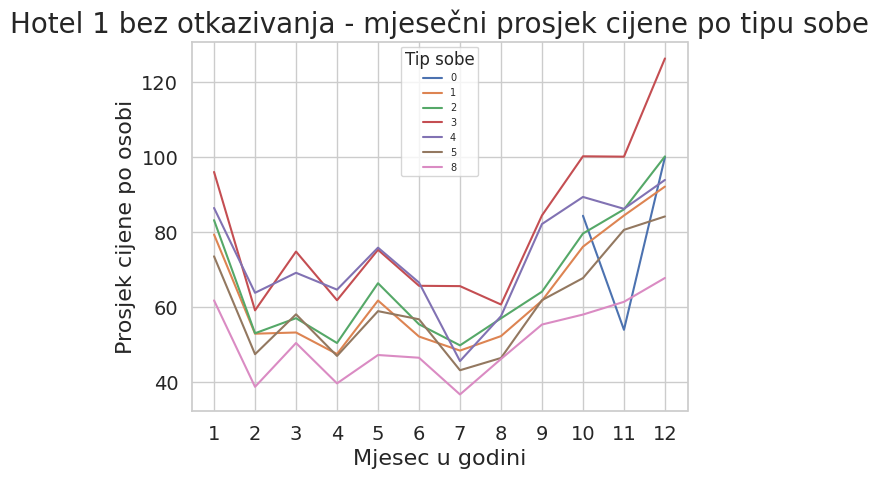

In [224]:
plt.figure(figsize=(28, 20))
average_by_monthly_room_type_hotel_one_no.unstack(level=1).plot()
plt.title('Hotel 1 bez otkazivanja - mjesečni prosjek cijene po tipu sobe', fontsize=20)
plt.xlabel('Mjesec u godini', fontsize=16)
plt.ylabel('Prosjek cijene po osobi', fontsize=16)
plt.xticks(range(1, 13), fontsize=14)
plt.yticks(fontsize=14)
plt.legend(title='Tip sobe', fontsize=7)
plt.show()





<Figure size 2800x2000 with 0 Axes>

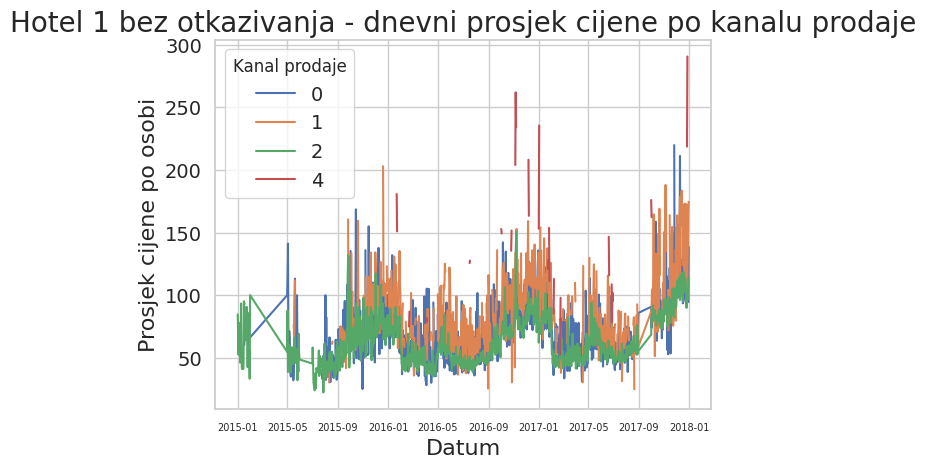

In [185]:
plt.figure(figsize=(28, 20))
average_by_daily_sales_channel_hotel_one_no.unstack(level=1).plot()
plt.title('Hotel 1 bez otkazivanja - dnevni prosjek cijene po kanalu prodaje', fontsize=20)
plt.xlabel('Datum', fontsize=16)
plt.ylabel('Prosjek cijene po osobi', fontsize=16)
plt.xticks(fontsize=7)
plt.yticks(fontsize=14)
plt.legend(title='Kanal prodaje', fontsize=14)
plt.show()

<Figure size 2800x2000 with 0 Axes>

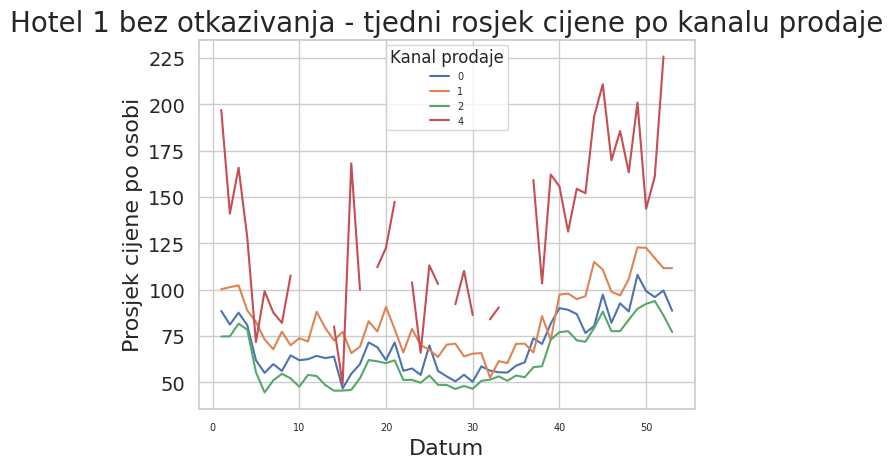

In [225]:
plt.figure(figsize=(28, 20))
average_by_weekly_sales_channel_hotel_one_no.unstack(level=1).plot()
plt.title('Hotel 1 bez otkazivanja - tjedni rosjek cijene po kanalu prodaje', fontsize=20)
plt.xlabel('Datum', fontsize=16)
plt.ylabel('Prosjek cijene po osobi', fontsize=16)
plt.xticks(fontsize=7)
plt.yticks(fontsize=14)
plt.legend(title='Kanal prodaje', fontsize=7)
plt.show()

<Figure size 2800x2000 with 0 Axes>

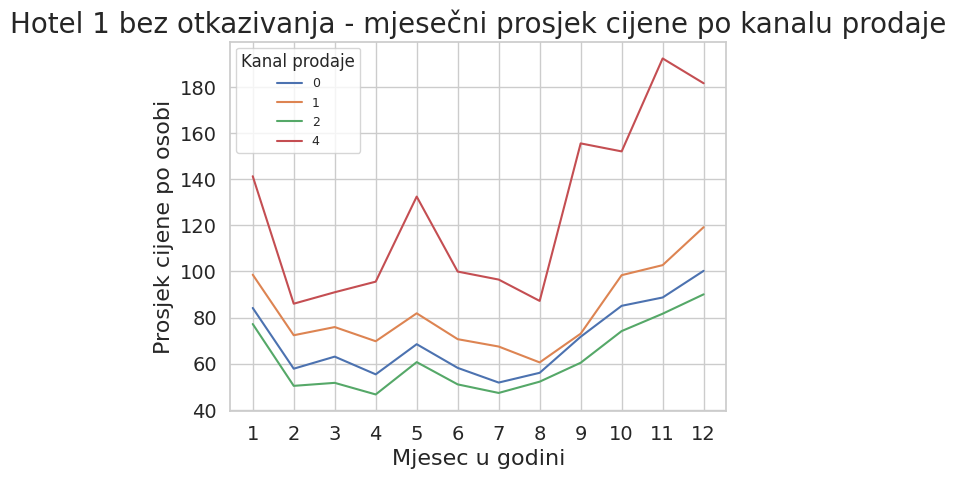

In [226]:
plt.figure(figsize=(28, 20))
average_by_monthly_sales_channel_hotel_one_no.unstack(level=1).plot()
plt.title('Hotel 1 bez otkazivanja - mjesečni prosjek cijene po kanalu prodaje', fontsize=20)
plt.xlabel('Mjesec u godini', fontsize=16)
plt.ylabel('Prosjek cijene po osobi', fontsize=16)
plt.xticks(range(1, 13), fontsize=14)
plt.yticks(fontsize=14)
plt.legend(title='Kanal prodaje', fontsize=9)
plt.show()

# Ostale analize i vizuali

### Datumi gdje je datum otkazivanja nakon datuma dolaska

In [255]:
krivi_datumi = data_cancellations[data_cancellations['datum_otkazivanja_rezervacije'] > data_cancellations['datum_dolaska']]
print(f"Ukupno {len(krivi_datumi)} redaka s neispravnim datumima")
print(krivi_datumi.head(3))

Ukupno 1950 redaka s neispravnim datumima
       hotel_id datum_dolaska datum_otkazivanja_rezervacije zemlja_gosta  \
11067         1    2015-01-01                    2015-07-01          PRT   
11072         1    2015-05-02                    2015-06-25          PRT   
11073         1    2015-05-02                    2015-07-02          PRT   

       kanal_prodaje_id  tip_sobe_id  cijena_nocenja  gost_id  ukupno_gostiju  \
11067                 2            1       97.930547  1048285               2   
11072                 2            1       72.739914  1019190               1   
11073                 2            1       81.380511  1001102               2   

       duljina_boravka  raspon_dolazak_rezervacija  
11067                4                           0  
11072                4                         105  
11073                5                          35  


### Vizualizacija ukupnog broja gostiju po danu, tjednu i mjesecu po hotelu